In [1]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace

def D_kl(p1,p2):
    C1 = np.einsum('ij,ik->ijk', p1, 1/p2) ###is it the right way?
    #print(C1)
    C2 = np.log(C1)
    #print(C2)
    C2[p1==0,:] = 0
    #print(C2)
    return np.einsum('ij,ijk->jk', p1, C2)

def D_kl_vec(p_y_x_hat):
    Dkl_vals = []
    for idx in range(p_y_x_hat.shape[1]):
        p_mean = np.mean(p_y_x_hat,axis=1)
        p_cur = p_y_x_hat[:,idx]
        dkl = sum([p_cur[x]*np.log(p_cur[x]/p_mean[x]) if (p_cur[x] > 0) else 0 for x in range(p_y_x_hat.shape[0])])
        #dkl = -sum([p_mean[x]*np.log(p_cur[x]/p_mean[x]) if (p_mean[x] > 0 and p_cur[x] > 0) else 0 for x in range(33)])
        Dkl_vals.append(dkl)
    return Dkl_vals

def IB_iter(p_x,p_y_x,p_x_hat_given_x, beta):
    if beta < 2800:
        #set_trace()
        pass
    p_x_hat = p_x_hat_given_x@p_x
    p_x_given_x_hat = (p_x_hat_given_x*p_x).T/(p_x_hat)
    #p_x_given_x_hat[np.isnan(p_x_given_x_hat)] = 0
    p_y_x_hat = p_y_x@p_x_given_x_hat
    not_norm = np.exp(-beta*D_kl(p_y_x,p_y_x_hat))*p_x_hat
    not_norm = not_norm.T
    return not_norm/np.sum(not_norm,axis = 0)

def prepare_prob(input_matrix):
    #input_matrix = abs(np.random.normal(2,1,(5,8)))
    p_y_x = input_matrix/np.sum(input_matrix,axis = 0)
    
    x_dim = p_y_x.shape[1]
    p_x = np.ones(x_dim)
    p_x = p_x/np.sum(p_x)
    
    p_x_hat_given_x = np.eye(x_dim) + abs(np.random.normal(0,0.02,(x_dim,x_dim)))
    p_x_hat_given_x = p_x_hat_given_x/np.sum(p_x_hat_given_x,axis = 0)
    
    return p_y_x,p_x,p_x_hat_given_x

def get_clusters(input_matrix,beta_values):
    p_y_x,p_x,p_x_hat_given_x = prepare_prob(input_matrix)

    beta_values = beta_values[::-1]

    clus = []
    full_distances = []
    clusters_matrix = []
    for beta in beta_values:
        err = 1
        #while err > 1e-7:
        while err > (1/beta)/10:
            prev_p = p_x_hat_given_x
            p_x_hat_given_x = IB_iter(p_x,p_y_x,p_x_hat_given_x, beta)
            err = np.sum(abs(prev_p-p_x_hat_given_x))

        p_x_hat = p_x_hat_given_x@p_x
        p_x_given_x_hat = (p_x_hat_given_x*p_x).T/(p_x_hat)

        p_y_x_hat = p_y_x@p_x_given_x_hat
        full_distances.append(D_kl_vec(p_y_x_hat))
        #clus.append(np.linalg.matrix_rank(p_y_x_hat, tol = 1e-7))
        #print(beta, np.linalg.matrix_rank(p_y_x_hat, tol = 1e-7))
        clus.append(np.linalg.matrix_rank(p_y_x_hat, tol = (1/beta)/10))
        #print(beta, np.linalg.matrix_rank(p_y_x_hat, tol = (1/beta)/10))
        t,indices  = np.unique(p_x_given_x_hat.round(decimals=int(np.ceil(np.log10(10*beta)))),axis=1,return_inverse = True)
        clusters_matrix.append(indices)
        #print(beta)
    #print(clusters_matrix)
        

    return clus,p_x_given_x_hat,p_y_x_hat,full_distances,clusters_matrix

In [2]:
## Read data:

#x = loadmat('C:\\Users\\Yoav\\Desktop\\ELSC\\Aviv\\Tali\\huji_data.mat')
x = loadmat("/ems/elsc-labs/mezer-a/nitai.seri/Desktop/IB-for-MRI/huji_data.mat")
MTsat,R1,MD,R2,MTV,R2s = 0,1,2,3,4,5
mean_values = {}
subjects = {}

gender = ['F','M','M','F','M','F','F','M','M','M','M','M','F','M','M','M','M','F','F','M','M','F','M','M','M','M','M','M','F','F','F','F','F','M','F','M','M','F','M','M','F','M','M','F','F']
age = ['26','30','27','27','27','27','26','57','69','31','26','27','61','63','75','57','27','23','25','68','70','71','65','63','73','24','31','73','25','65','27','29','26','31','77','27','26','24','67','75','69','32','30','25','24']
subj_id = [str(x+1) for x in range(45)]
sub = np.array(list(zip(subj_id,age,gender)))

for ix in range(6):
    subjects[ix] = sub.copy()
    mean_values[ix] = x['huji_data']['data'][0][0][:,:,ix]
    
    mean_values[ix] = np.delete(mean_values[ix],29,0) #remove Left Accumbens
    mean_values[ix] = np.delete(mean_values[ix],20,0) #remove Medulla
    mean_values[ix] = np.delete(mean_values[ix],8,0) #remove Right Accumbens
    
    subjects[ix] = subjects[ix][~np.isnan(mean_values[ix].T).any(axis=1)]
    mean_values[ix] = (mean_values[ix].T[~np.isnan(mean_values[ix].T).any(axis=1)]).T


    
area_names = ['Left-Thalamus','Left-Caudate','Left-Putamen','Left-Pallidum','Left-Hippocampus','Left-Cerebellum-White-Matter','Left-Cerebellum-Cortex','Left-Amygdala','Left-Accumbens-area','left-ctx-frontal','left-ctx-parietal','left-ctx-temporal','left-ctx-occipital','left-wm-frontal','left-wm-parietal','left-wm-temporal','left-wm-occipital','CC','Midbrain','Pons','Medulla','Right-Thalamus','Right-Caudate','Right-Putamen','Right-Pallidum','Right-Hippocampus','Right-Cerebellum-White-Matter','Right-Cerebellum-Cortex','Right-Amygdala','Right-Accumbens-area','Right-ctx-frontal','Right-ctx-parietal','Right-ctx-temporal','Right-ctx-occipital','Right-wm-frontal','Right-wm-parietal','Right-wm-temporal','Right-wm-occipital']
area_names = ['Thalamus L','Caudate L','Putamen L','Pallidum L','Hippocampus L','wm-cerebellum L','ctx-cerebellum L','Amygdala L','Accumbens-area L','ctx-frontal L','ctx-parietal L','ctx-temporal L','ctx-occipital L','wm-frontal L','wm-parietal L','wm-temporal L','wm-occipital L','corpus callosum','Midbrain','Pons','Medulla','Thalamus R','Caudate R','Putamen R','Pallidum R','Hippocampus R','wm-cerebellum R','ctx-cerebellum R','Amygdala R','Accumbens-area R','ctx-frontal R','ctx-parietal R','ctx-temporal R','ctx-occipital R','wm-frontal R','wm-parietal R','wm-temporal R','wm-occipital R']
del area_names[29] #remove Left Accumbens
del area_names[20] #remove Medulla
del area_names[8] #remove Right Accumbens
print(len(area_names))
for ix in range(6):
    print(subjects[ix].shape)
    print(mean_values[ix].shape)
    
#area_types = ['Left-Thalamus','Left-Caudate','Left-Putamen','Left-Pallidum','Left-Hippocampus','wm','ctx','Left-Amygdala','Left-Accumbens-area','ctx','ctx','ctx','ctx','wm','wm','wm','wm','wm','Midbrain','Pons','Medulla','Right-Thalamus','Right-Caudate','Right-Putamen','Right-Pallidum','Right-Hippocampus','wm','ctx','Right-Amygdala','Right-Accumbens-area','ctx','ctx','ctx','ctx','wm','wm','wm','wm']
area_types = ['other','bg','bg','bg','limbic','wm','ctx','limbic','bg','ctx','ctx','ctx','ctx','wm','wm','wm','wm','wm','other','other','other','other','bg','bg','bg','limbic','wm','ctx','limbic','bg','ctx','ctx','ctx','ctx','wm','wm','wm','wm']
del area_types[29] #remove Left Accumbens
del area_types[20] #remove Medulla
del area_types[8] #remove Right Accumbens
region = {}
for x,y in zip(area_names,area_types):
    region[x] = y

35
(45, 3)
(35, 45)
(45, 3)
(35, 45)
(37, 3)
(35, 37)
(40, 3)
(35, 40)
(45, 3)
(35, 45)
(39, 3)
(35, 39)


In [3]:
## Run analysis:
def generate_beta(max_value = 20000, length = 800):
    beta_values = [max_value]
    for idx in range(length-1):
        beta_values.append(beta_values[-1]*0.99)
    return beta_values[::-1]

contrast = MTV
analyse_areas = False #if False, analyse subjects (take transpose of the matrix)

input_matrix = mean_values[contrast]
#input_matrix = np.exp(mean_values[contrast]**2)
# input_matrix = np.exp(-1/mean_values[contrast])  ###for MTV
#input_matrix = mean_values[contrast]**4  ###for R2s
#input_matrix = np.exp(-1/mean_values[contrast]**2)  ###for MD
print(np.max(input_matrix))
print(np.min(input_matrix))
if analyse_areas:
    input_matrix = input_matrix.T
beta_values = generate_beta(10000,800)
clus,p_x_given_x_hat,p_y_x_hat,full_distances,clusters_matrix = get_clusters(input_matrix,beta_values)

print("Done")

0.3448758125305176
0.1581858992576599


<ipython-input-1-9514f508696b>:30: RuntimeWarning: invalid value encountered in true_divide
  p_x_given_x_hat = (p_x_hat_given_x*p_x).T/(p_x_hat)


Done


(200.0, 6000.0, 0.0, 0.005)

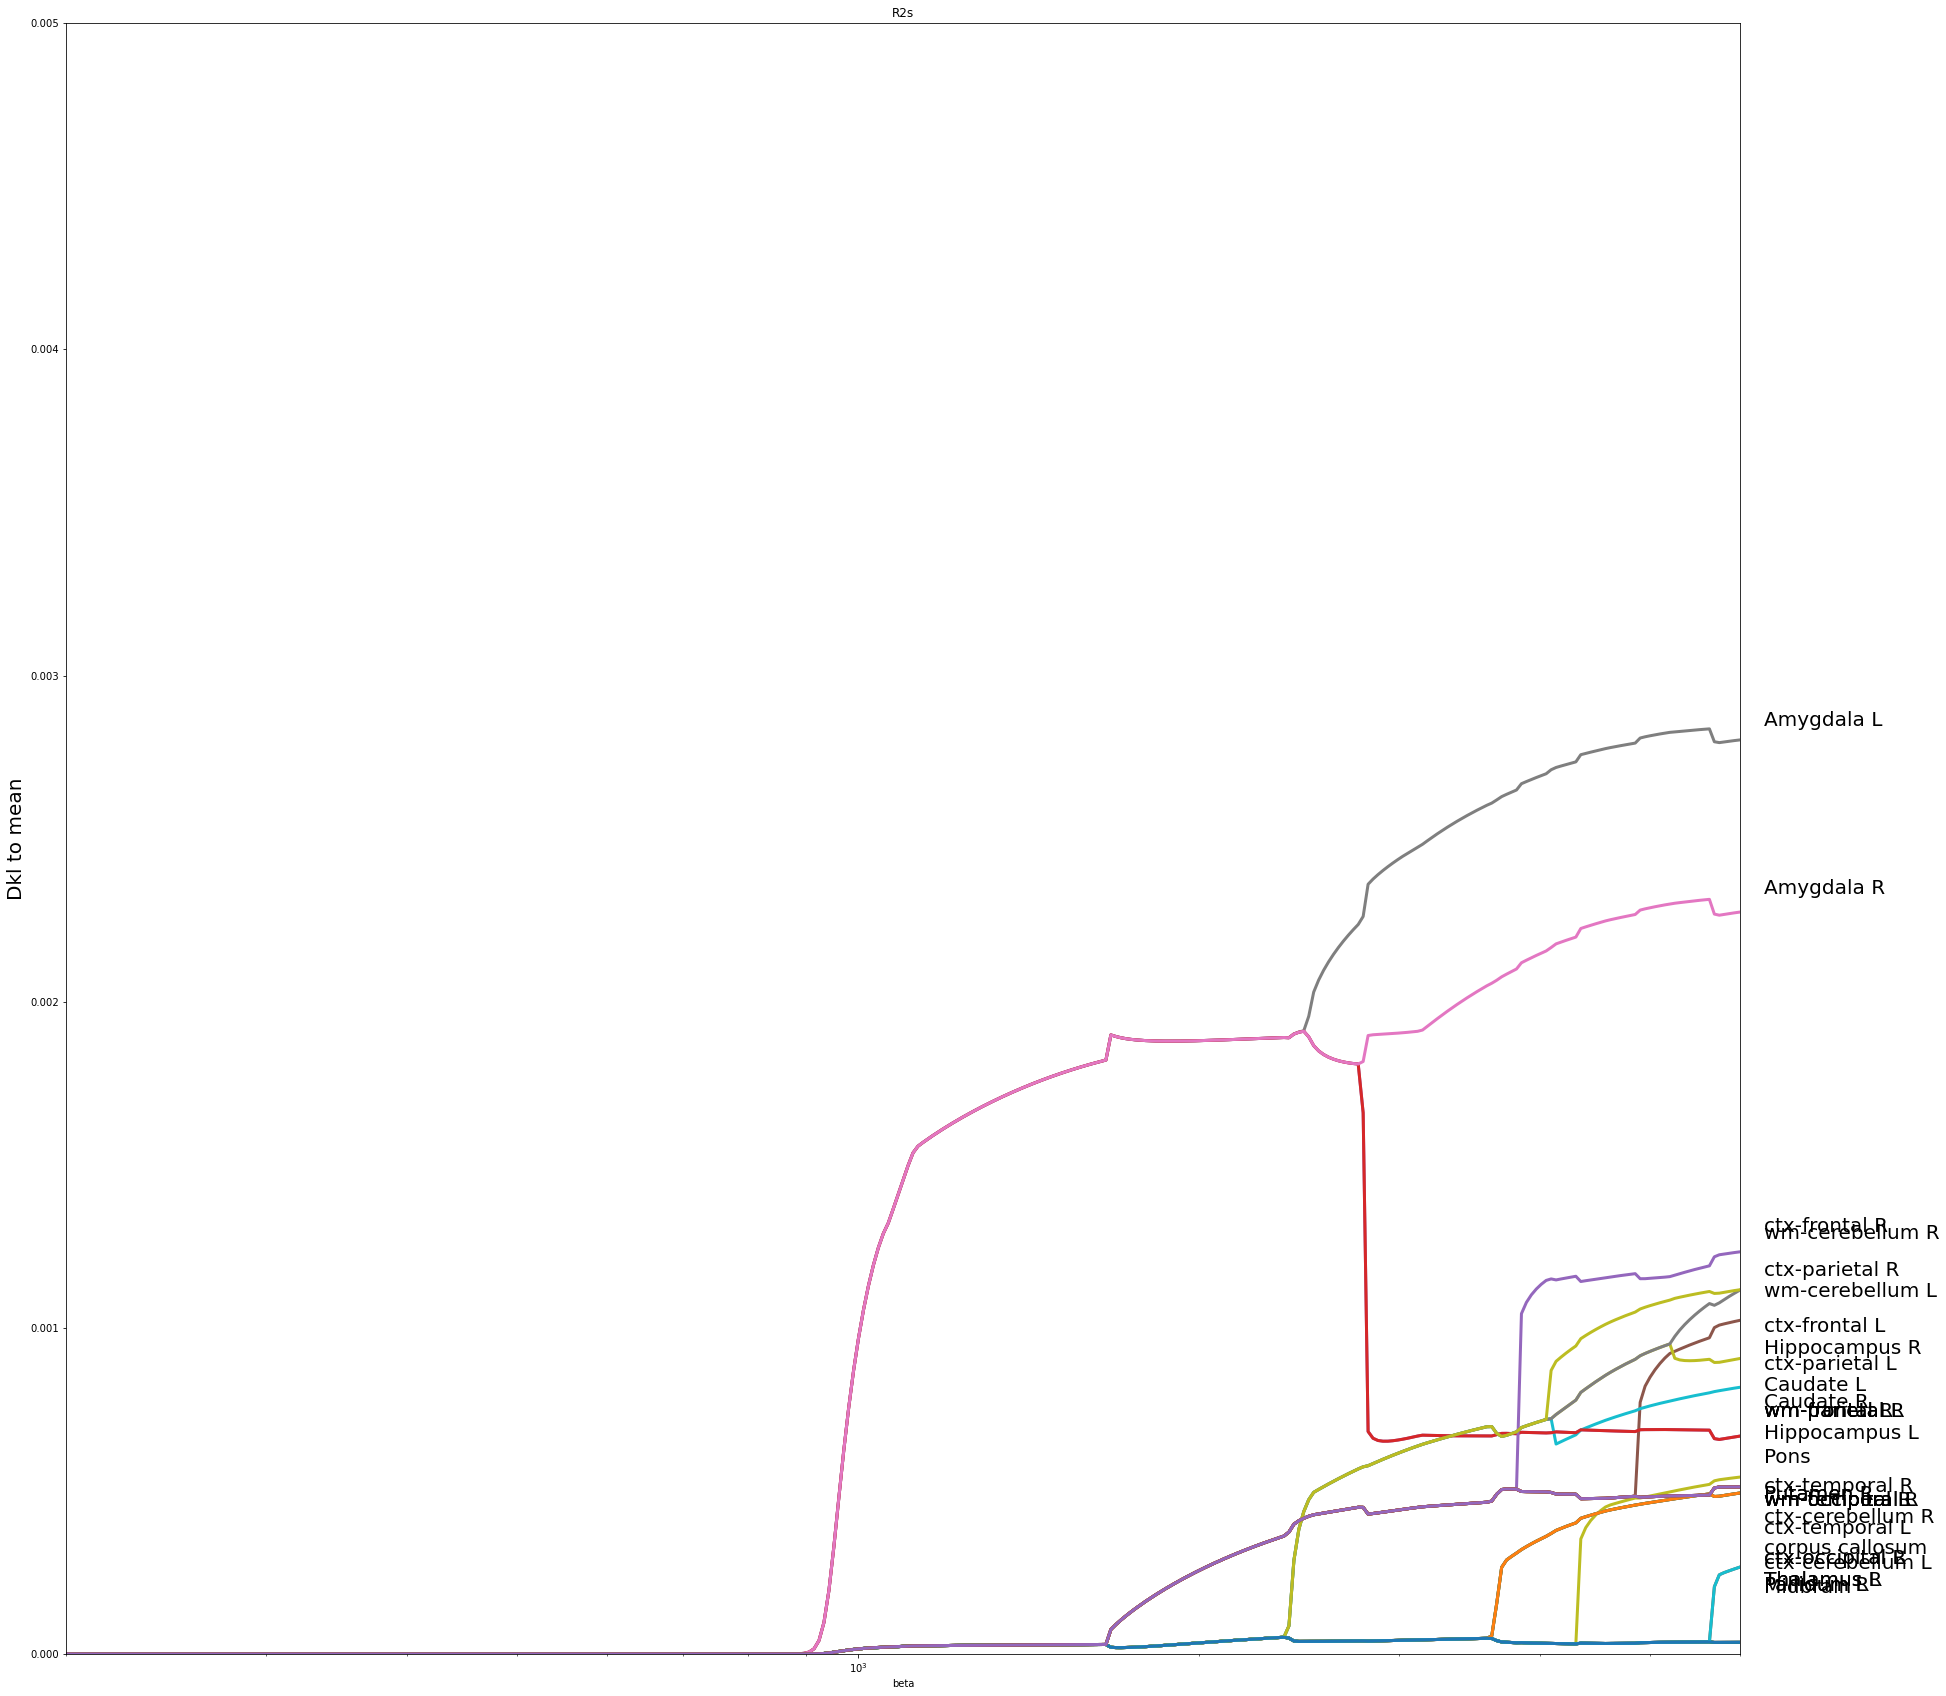

In [19]:
## Plot results:
def subj_to_text(subj):
    #return 'ID: ' + subj[0] + ' Age: ' + subj[1] + ' ' + subj[2]
    return 'Age: ' + subj[1] + ' (' + subj[2] + ')'

#plot_axis = [1, max(beta_values), 0,max(max(full_distances))*1.10]
plot_axis = [200, 6000, 0,0.005]
#plot_axis = [1000, 5000, 0,0.015]



## plot bifrucation diagram:
plt.figure(figsize=(30,30))
plt.rcParams["figure.figsize"]=30,30
fd = np.array(full_distances)

## separate white:
#for idx in range(fd.shape[1]):
    #if 'wm' in area_names[idx] or 'White' in area_names[idx] or area_names[idx] == 'CC':
    #if 'ctx' in area_names[idx]:
#        fd[:500,idx] = -fd[:500,idx]

for idx in range(fd.shape[1]):
    plt.plot(beta_values[::-1],fd[:,idx],linewidth=3)

#plot legend
for idx in range(p_y_x_hat.shape[1]):
    text_condition = fd[0,idx] < plot_axis[3]
    text_condition = True
    if not(fd[0,idx] == np.inf):
        if text_condition:
            if analyse_areas:
                plt.text(plot_axis[1]*1.05, fd[0,idx],area_names[idx],fontsize=20) #,rotation=45,rotation_mode = "anchor")
            else:
                plt.text(plot_axis[1]*1.05, fd[0,idx],subj_to_text(subjects[contrast][idx]),fontsize=20) #,rotation=45,rotation_mode = "anchor")

plt.title('R2s')
plt.xscale("log")
plt.xlabel('beta')
plt.ylabel('Dkl to mean', fontsize=20)
plt.axis(plot_axis)
#plt.savefig('C:\\Users\\Yoav\\Desktop\\ELSC\\Aviv\\Tali\\IB\\MTV2.png')

In [20]:
def find_multi(tt,x):
    return [i for i, y in enumerate(tt) if y == x]

tt = np.array(clusters_matrix)
num = tt.shape[1]
idx_lst = list(range(num))
cntr = num
print(idx_lst)
Z = []
running_idx = 1

def clus_iter(tt,cntr,idx_lst,iter_num,Z,running_idx):
    pp = list(tt[iter_num,:])
    for x in set(pp):
        if list(pp).count(x) > 1 and x != -1:
            idxs = find_multi(pp,x)
            if len(idxs) > 2:
                print('oops', idxs)
            tt[:,idxs[0]] = -1
            print('merge ' + str(idx_lst[idxs[1]]) + ' and ' + str(idx_lst[idxs[0]]) + ' into ' + str(cntr))
            Z.append([idx_lst[idxs[1]], idx_lst[idxs[0]], iter_num, running_idx])
            idx_lst[idxs[1]] = cntr
            idx_lst[idxs[0]] = cntr
            cntr += 1
            running_idx += 1
    
    return tt,cntr,idx_lst,Z,running_idx
    
    
#print(tt.shape[0])

#for idx in range(-1,-tt.shape[0]-1,-1):
for idx in range(tt.shape[0]):
    tt,cntr,idx_lst,Z,running_idx = clus_iter(tt,cntr,idx_lst,idx,Z,running_idx)

Z = np.array(Z,dtype = 'double')
#print(tt[-16,:])
#print(tt[-20,:])
#print(idx_lst)

#print(area_names[19])
print(Z)
Z[:,2] = Z[:,2]-min(Z[:,2])

for i in range(Z.shape[0]):
    Z[i,2] = i*5
    #if Z[i,0] > 27:
    #    Z[i,0] = Z[i,0] - 1
    #if Z[i,1] > 27:
    #    Z[i,1] = Z[i,1] - 1
        
#Z = Z[:-1,:]
#print(Z)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]
oops [12, 13, 31, 32]
merge 13 and 12 into 35
merge 21 and 2 into 36
oops [14, 15, 33, 34]
merge 15 and 14 into 37
merge 22 and 3 into 38
merge 19 and 0 into 39
oops [13, 31, 32]
merge 31 and 35 into 40
oops [15, 33, 34]
merge 33 and 37 into 41
merge 30 and 11 into 42
merge 32 and 40 into 43
merge 34 and 41 into 44
merge 20 and 1 into 45
merge 44 and 16 into 46
merge 23 and 4 into 47
merge 39 and 17 into 48
merge 42 and 6 into 49
merge 46 and 43 into 50
merge 36 and 45 into 51
merge 38 and 48 into 52
merge 49 and 52 into 53
merge 53 and 10 into 54
merge 29 and 25 into 55
merge 54 and 55 into 56
merge 27 and 8 into 57
merge 50 and 5 into 58
merge 56 and 18 into 59
merge 57 and 9 into 60
merge 28 and 60 into 61
merge 58 and 24 into 62
merge 59 and 51 into 63
merge 26 and 47 into 64
merge 63 and 61 into 65
merge 64 and 7 into 66
merge 62 and 65 into 67
merge 6

In [6]:
a=np.array([2,3])
b=np.array([0,1])
b = a/b
b[0]

<ipython-input-6-e84732a499ed>:3: RuntimeWarning: divide by zero encountered in true_divide
  b = a/b


inf

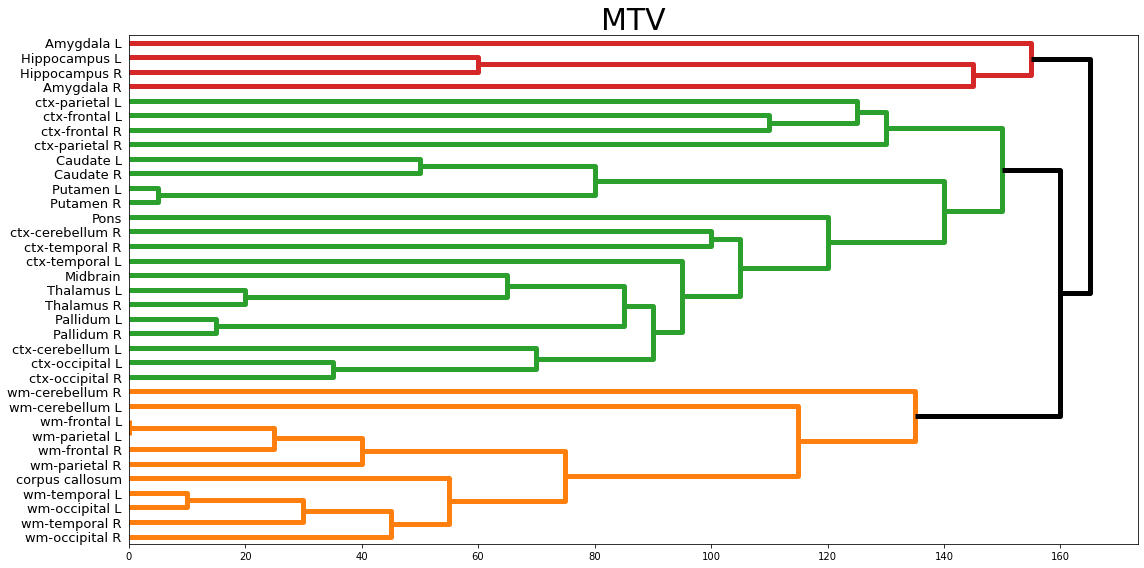

In [11]:
from scipy.cluster import hierarchy
import matplotlib

# Override the default linewidth.
matplotlib.rcParams['lines.linewidth'] = 5

fig, ax = plt.subplots(1,1)
ax.set_title('MTV', fontsize=30)
fig.set_size_inches(16,8)
#dn = hierarchy.dendrogram(Z,labels=area_names,leaf_rotation=-80, ax=ax)
if analyse_areas:
    dn = hierarchy.dendrogram(Z,labels=area_names, ax=ax, orientation = 'right',color_threshold = 160,above_threshold_color='k')
    #dn = hierarchy.dendrogram(Z,labels=area_names, ax=ax, color_threshold = 160,above_threshold_color='k',leaf_rotation=-80)
else:
    #dn = hierarchy.dendrogram(Z,labels=[subj_to_text(x) for x in subjects[contrast]],orientation = 'right',leaf_rotation=-80, ax=ax)
    dn = hierarchy.dendrogram(Z,labels=[subj_to_text(x) for x in subjects[contrast]],
                              ax=ax,leaf_rotation=-80,color_threshold = 205, above_threshold_color='k')
    #dn = hierarchy.dendrogram(Z,labels=[subj_to_text(x) for x in subjects[contrast]],
    #                          ax=ax,color_threshold = 300, above_threshold_color='k',orientation = 'right')
#dn = hierarchy.dendrogram(Z,labels=area_names, ax=ax)
#dn = hierarchy.dendrogram(Z,leaf_rotation=-80, ax=ax)
#ax.tick_params(axis='x',which = 'major', labelsize=15)
ax.tick_params(axis='y',which = 'major', labelsize=13)
plt.tight_layout()

#hierarchy.set_link_color_palette(['#045a8d', '#2b8cbe', '#74a9cf', '#a6bddb'])
#hierarchy.set_link_color_palette(['#8dd3c7','#ffffb3','#bebada','#fb8072','#80b1d3','#fdb462'][::-1])
#hierarchy.set_link_color_palette(['#66c2a5','#fc8d62','#8da0cb','#e78ac3'][::-1])
#hierarchy.set_link_color_palette(['#993404','#406020','#fd8d3c','#732673'][::-1])
hierarchy.set_link_color_palette(['#993404','#64ad30','#a2142e','#7e2f8e'][::-1])
#bordo: a2142e
#orange: d95319
#yellow: eeb220


#region_color = {'other':'k','bg':'y','limbic':'b','ctx':'r','wm':'g'}
#region_color = {'other':'k','bg':'#1f78b4','limbic':'k','ctx':'#e31a1c','wm':'#33a02c'}
region_color = {'other':'#aaaaaa','bg':'#aaaaaa','limbic':'#aaaaaa','ctx':'#636363','wm':'k'}

# if analyse_areas:
#     for ticklabel in plt.gca().get_yticklabels():
#         ticklabel.set_color(region_color[region[ticklabel.get_text()]])
#     plt.tick_params(
#         axis='x',          # changes apply to the x-axis
#         which='both',      # both major and minor ticks are affected
#         bottom=False,      # ticks along the bottom edge are off
#         top=False,         # ticks along the top edge are off
#         labelbottom=False)
#     plt.xlabel('Clustering level')
# else:
#     for ticklabel in plt.gca().get_yticklabels():
#         if int(subjects[contrast][int(ticklabel.get_text())][1])>50:
#         #if int(ticklabel.get_text()[5:7])>50:
#             ticklabel.set_color('#636363')
#         else:
#             ticklabel.set_color('k')
#             ticklabel.set_fontweight('bold')

    
#hierarchy.set_link_color_palette(None)
#print([subj_to_text(x) for x in subjects[contrast]])
#plt.savefig('C:\\Users\\Yoav\\Desktop\\ELSC\\Aviv\\Tali\\IB\\MTV_for_grant4.png')
#plt.savefig('C:\\Users\\Yoav\\Desktop\\ELSC\\Aviv\\Tali\\grant\\MTV_areas4.png')
# plt.savefig('D:\\ELSC\\Aviv\\Tali\\grant\\new_MTV_6.png')

[6 5 5 6 3 4 6 0 2 2 6 6 4 4 4 4 4 6 6 6 5 5 6 3 4 6 1 2 2 6 6 4 4 4 4]
(45, 35)
ShapiroResult(statistic=0.9309542179107666, pvalue=2.3247735499095084e-26)
0 Thalamus L
3 Pallidum L
6 ctx-cerebellum L
10 ctx-temporal L
11 ctx-occipital L
17 Midbrain
18 Pons
19 Thalamus R
22 Pallidum R
25 ctx-cerebellum R
29 ctx-temporal R
30 ctx-occipital R


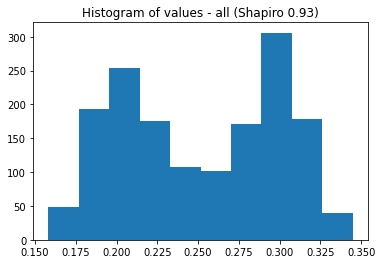

In [18]:
# I need to check normality of p(y|xhat), where xhat are the areas?
from scipy import stats
#shapiro_test = stats.shapiro(x)
#shapiro_test
# 45 subjects
# p_y_x_hat.shape
clus_areas = clus.copy()
clusters_matrix_areas = clusters_matrix.copy()
print(clusters_matrix_areas[100])
print(input_matrix.shape)
print(stats.shapiro((input_matrix[:,clusters_matrix_areas[100]<=6])))
# stats.shapiro(input_matrix[1,clusters_matrix_subjects[400]==3])
plt.hist((np.matrix.flatten(input_matrix[:,clusters_matrix_areas[100]<=6])))
plt.title('Histogram of values - all (Shapiro 0.93)')
for i in range(len(clusters_matrix_areas[100])):
    if clusters_matrix_areas[100][i] == 6:
        print(i, area_names[i])
# list(clusters_matrix_areas[500]==0)]
# plt.savefig('D:\\ELSC\\Aviv\\Tali\\right_norm\\x\\all.png')

In [12]:
sima = np.genfromtxt('C:\\Users\\Yoav\\Desktop\\ELSC\\Sima\\sorted_counts.csv', delimiter=',')
sima.shape

## Run analysis:
def generate_beta(max_value = 20000, length = 800):
    beta_values = [max_value]
    for idx in range(length-1):
        beta_values.append(beta_values[-1]*0.99)
    return beta_values[::-1]

contrast = MTV
analyse_areas = True #if False, analyse subjects

#input_matrix = mean_values[contrast]
#input_matrix = np.exp(mean_values[contrast]**2)
input_matrix = sima+500  ###for MTV
#input_matrix = mean_values[contrast]**4  ###for R2s
#input_matrix = np.exp(-1/mean_values[contrast]**2)  ###for MD
print(np.max(input_matrix))
print(np.min(input_matrix))
if analyse_areas:
    input_matrix = input_matrix.T
beta_values = generate_beta(10000,800)
clus,p_x_given_x_hat,p_y_x_hat,full_distances,clusters_matrix = get_clusters(input_matrix,beta_values)

print("Done")

OSError: C:\Users\Yoav\Desktop\ELSC\Sima\sorted_counts.csv not found.

In [182]:
# np.savetxt("C:\\Users\\Yoav\\Desktop\\ELSC\\Sima\\clus.csv", clus, delimiter=",")
# np.savetxt("C:\\Users\\Yoav\\Desktop\\ELSC\\Sima\\p_x_given_x_hat.csv", p_x_given_x_hat, delimiter=",")
# np.savetxt("C:\\Users\\Yoav\\Desktop\\ELSC\\Sima\\p_y_x_hat.csv", p_y_x_hat, delimiter=",")
# np.savetxt("C:\\Users\\Yoav\\Desktop\\ELSC\\Sima\\full_distances.csv", full_distances, delimiter=",")
# np.savetxt("C:\\Users\\Yoav\\Desktop\\ELSC\\Sima\\clusters_matrix.csv", clusters_matrix, delimiter=",")